In [35]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

### Connection to the database and understanding it

In [5]:
# Connect to the SQLite DB
conn = sqlite3.connect("database/database/german_credit.db")
pd.read_sql("PRAGMA table_info(credit_data);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,Status_of_existing_checking_account,TEXT,0,None,0
1,1,Duration_in_month,INTEGER,0,None,0
2,2,Credit_history,TEXT,0,None,0
3,3,Purpose,TEXT,0,None,0
4,4,Credit_amount,INTEGER,0,None,0
5,5,Savings_account_bonds,TEXT,0,None,0
6,6,Present_employment_since,TEXT,0,None,0
7,7,Installment_rate_in_percentage_of_disposable_i...,INTEGER,0,None,0
8,8,Personal_status_and_sex,TEXT,0,None,0
9,9,Other_debtors_guarantors,TEXT,0,None,0


In [9]:
pd.read_sql("SELECT COUNT(*) as row_count FROM credit_data;", conn)

,row_count
0,1000


In [10]:
len(pd.read_sql("PRAGMA table_info(credit_data);", conn))

21

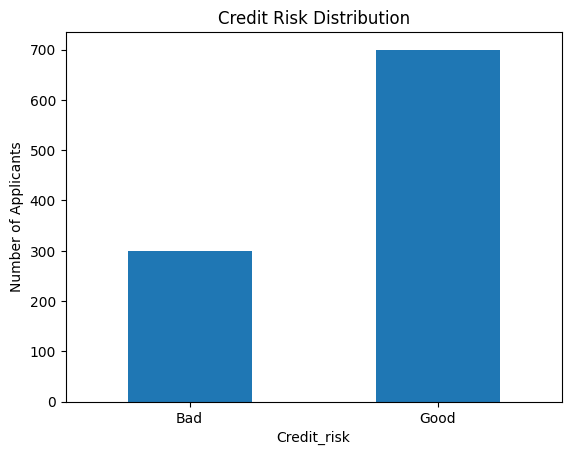

In [12]:
risk_dist = pd.read_sql("""
    SELECT Credit_risk, COUNT(*) AS count
    FROM credit_data
    GROUP BY Credit_risk;
""", conn)

risk_dist['Credit_risk'] = risk_dist['Credit_risk'].map({1: 'Good', 0: 'Bad'})
risk_dist.set_index("Credit_risk").plot(kind="bar", legend=False)
plt.title("Credit Risk Distribution")
plt.ylabel("Number of Applicants")
plt.xticks(rotation=0)
plt.show()


In [13]:
pd.read_sql("""
    SELECT Credit_risk, AVG(Credit_amount) AS avg_credit
    FROM credit_data
    GROUP BY Credit_risk;
""", conn)

,Credit_risk,avg_credit
0,0,3938.126667
1,1,2985.457143


In [14]:
pd.read_sql("""SELECT Present_employment_since, 
       AVG(Credit_risk) AS risk_rate
FROM credit_data
GROUP BY Present_employment_since
ORDER BY risk_rate ASC;
""", conn)

,Present_employment_since,risk_rate
0,A72,0.593023
1,A71,0.629032
2,A73,0.693215
3,A75,0.747036
4,A74,0.775862


In [15]:
pd.read_sql("""SELECT Personal_status_and_sex,
       COUNT(*) AS total,
       AVG(Credit_risk) AS good_credit_ratio
FROM credit_data
GROUP BY Personal_status_and_sex
ORDER BY good_credit_ratio ASC;
""", conn)

,Personal_status_and_sex,total,good_credit_ratio
0,A91,50,0.600000
1,A92,310,0.648387
2,A94,92,0.728261
3,A93,548,0.733577


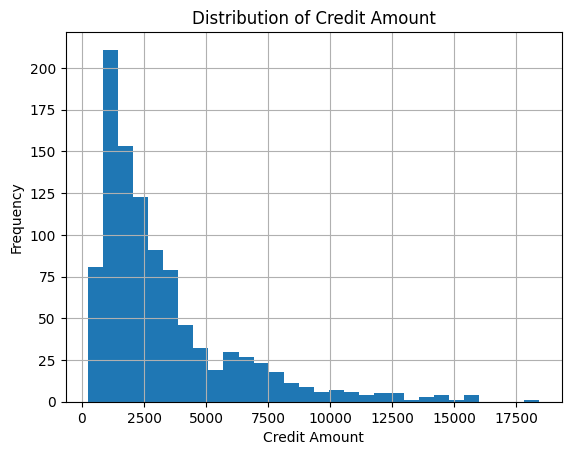

In [16]:
credit_amounts = pd.read_sql("SELECT Credit_amount FROM credit_data;", conn)
credit_amounts.hist(bins=30)
plt.title("Distribution of Credit Amount")
plt.xlabel("Credit Amount")
plt.ylabel("Frequency")
plt.show()


### Pre-processing data

In [18]:
df = pd.read_sql("SELECT * FROM credit_data;", conn)

df.head()

,Status_of_existing_checking_account,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,foreign_worker,Credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [19]:
df.dtypes

Status_of_existing_checking_account                         object
Duration_in_month                                            int64
Credit_history                                              object
Purpose                                                     object
Credit_amount                                                int64
Savings_account_bonds                                       object
Present_employment_since                                    object
Installment_rate_in_percentage_of_disposable_income          int64
Personal_status_and_sex                                     object
Other_debtors_guarantors                                    object
Present_residence_since                                      int64
Property                                                    object
Age_in_years                                                 int64
Other_installment_plans                                     object
Housing                                                     ob

In [22]:
# Check for NaNs
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)


Missing values per column:
 Status_of_existing_checking_account                         0
Duration_in_month                                           0
Credit_history                                              0
Purpose                                                     0
Credit_amount                                               0
Savings_account_bonds                                       0
Present_employment_since                                    0
Installment_rate_in_percentage_of_disposable_income         0
Personal_status_and_sex                                     0
Other_debtors_guarantors                                    0
Present_residence_since                                     0
Property                                                    0
Age_in_years                                                0
Other_installment_plans                                     0
Housing                                                     0
Number_of_existing_credits_at_this_bank   

In [21]:
# One-hot encode categorical variables
categorical_cols = [
    "Status_of_existing_checking_account", "Credit_history", "Purpose",
    "Savings_account_bonds", "Present_employment_since",
    "Personal_status_and_sex", "Other_debtors_guarantors", "Property",
    "Other_installment_plans", "Housing", "Job", "Telephone", "foreign_worker"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scale continuous numeric features
scaler = StandardScaler()
numerical_cols = ["Duration_in_month", "Credit_amount", "Installment_rate_in_percentage_of_disposable_income",
                  "Present_residence_since", "Age_in_years", "Number_of_existing_credits_at_this_bank",
                  "Number_of_people_being_liable_to_provide_maintenance_for"]

df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Optional: reorder columns so target is at the end
target = df_encoded.pop("Credit_risk")
df_encoded["Credit_risk"] = target


In [23]:
# Save cleaned version into SQLite
df_encoded.to_sql("cleaned_credit_data", conn, if_exists="replace", index=False)

# Confirm save
print("✅ Cleaned data saved to 'cleaned_credit_data' table.")
print(pd.read_sql("SELECT * FROM cleaned_credit_data LIMIT 5;", conn))

# Optional: list of all columns
print("Cleaned data shape:", df_encoded.shape)


✅ Cleaned data saved to 'cleaned_credit_data' table.
   Duration_in_month  Credit_amount  \
0          -1.236478      -0.745131   
1           2.248194       0.949817   
2          -0.738668      -0.416562   
3           1.750384       1.634247   
4           0.256953       0.566664   

   Installment_rate_in_percentage_of_disposable_income  \
0                                           0.918477     
1                                          -0.870183     
2                                          -0.870183     
3                                          -0.870183     
4                                           0.024147     

   Present_residence_since  Age_in_years  \
0                 1.046987      2.766456   
1                -0.765977     -1.191404   
2                 0.140505      1.183312   
3                 1.046987      0.831502   
4                 1.046987      1.535122   

   Number_of_existing_credits_at_this_bank  \
0                                 1.027079   
1     

### Feature engineering

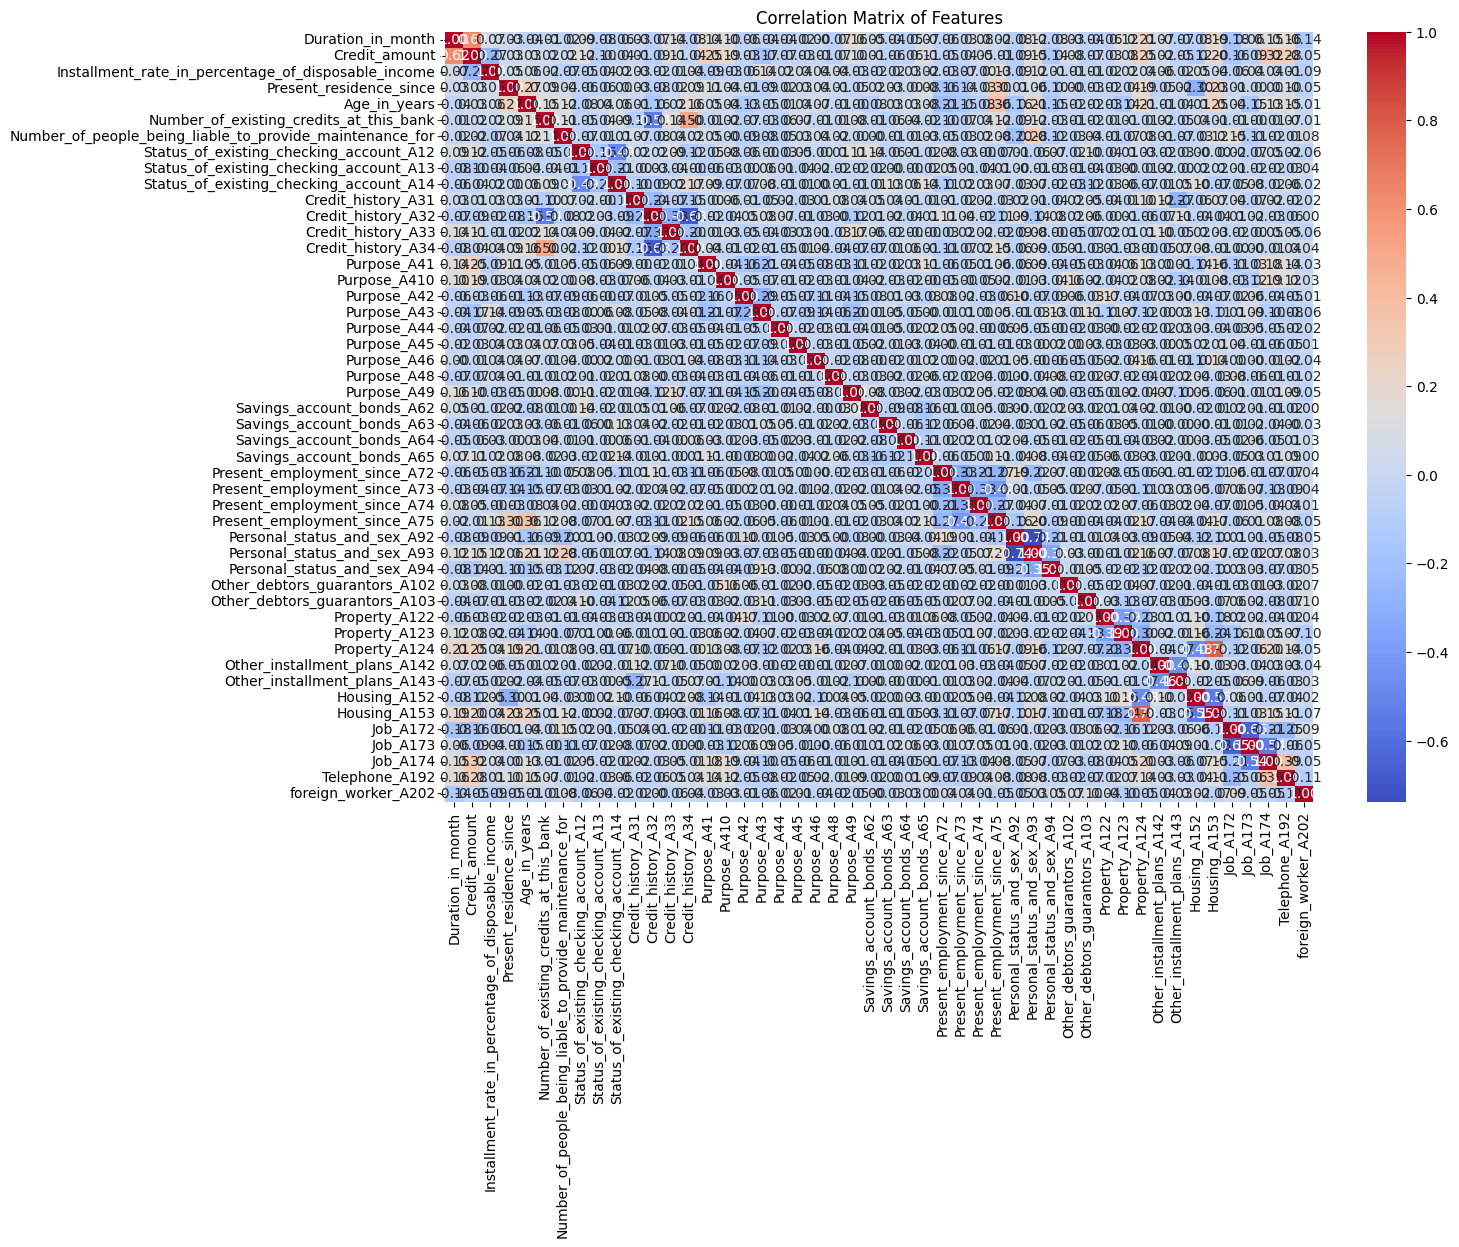

In [26]:
# Subset only numerical columns (after encoding and scaling)
numeric_df = df_encoded.select_dtypes(include='number')

# Remove target variable temporarily
correlation_matrix = numeric_df.drop(columns=["Credit_risk"]).corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

In [27]:
# Correlation of features with target
target_corr = numeric_df.corr()["Credit_risk"].sort_values(ascending=False)

# Print top and bottom 5
print("Top features positively correlated with Credit_risk:\n", target_corr.head())
print("\nTop features negatively correlated with Credit_risk:\n", target_corr.tail())


Top features positively correlated with Credit_risk:
 Credit_risk                                1.000000
Status_of_existing_checking_account_A14    0.322436
Credit_history_A34                         0.181713
Housing_A152                               0.134589
Savings_account_bonds_A65                  0.129238
Name: Credit_risk, dtype: float64

Top features negatively correlated with Credit_risk:
 Status_of_existing_checking_account_A12   -0.119581
Property_A124                             -0.125750
Credit_history_A31                        -0.134448
Credit_amount                             -0.154739
Duration_in_month                         -0.214927
Name: Credit_risk, dtype: float64


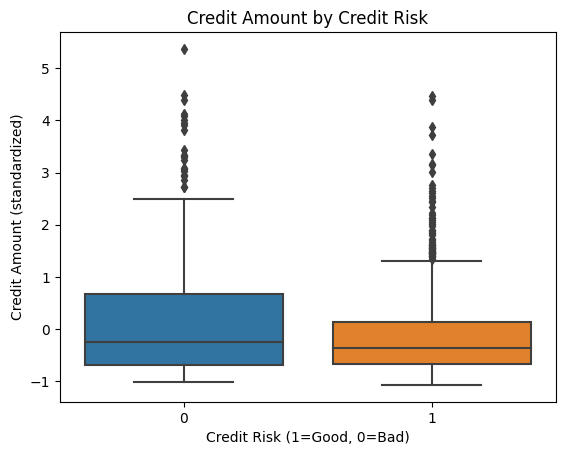

In [28]:
# Example: Credit_amount vs. Credit_risk
sns.boxplot(data=df_encoded, x="Credit_risk", y="Credit_amount")
plt.title("Credit Amount by Credit Risk")
plt.xlabel("Credit Risk (1=Good, 0=Bad)")
plt.ylabel("Credit Amount (standardized)")
plt.show()

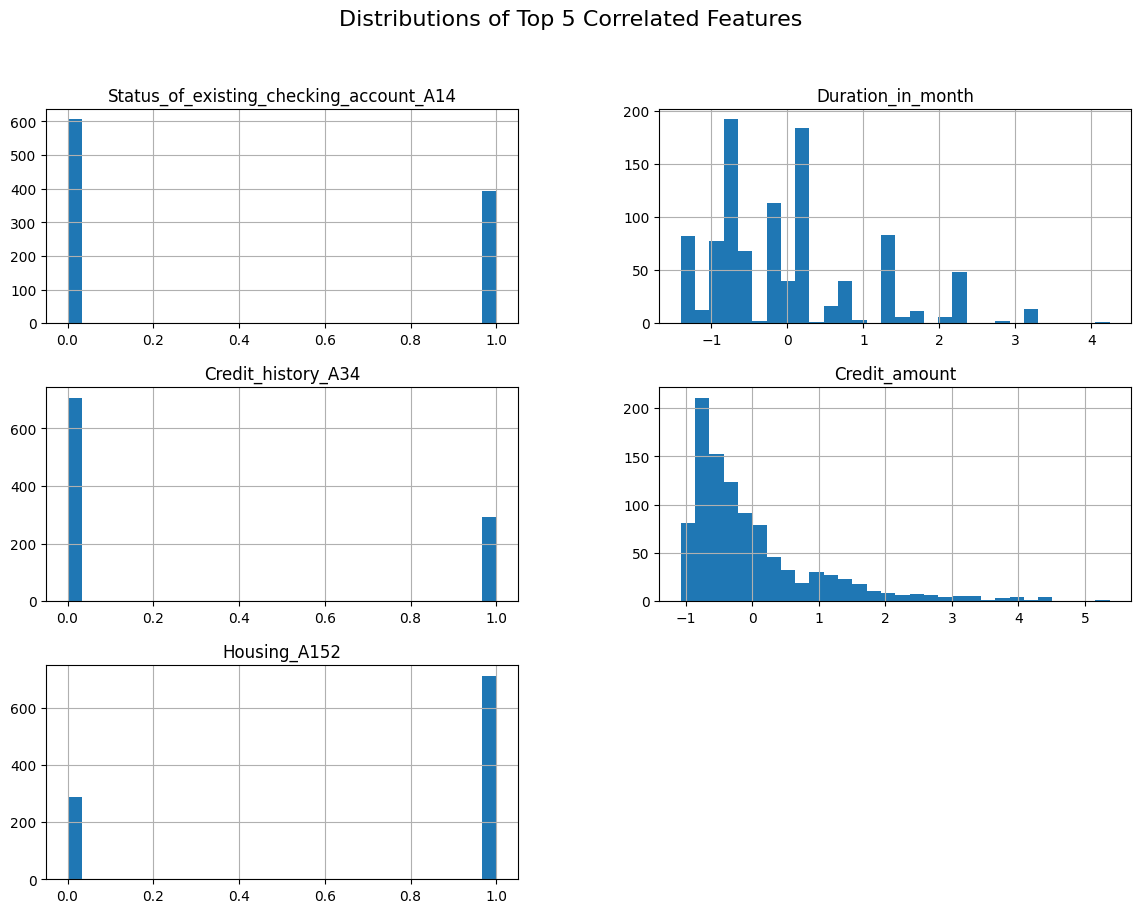

In [29]:
top_corr_features = target_corr.drop("Credit_risk").abs().sort_values(ascending=False).head(5).index.tolist()

df_encoded[top_corr_features].hist(bins=30, figsize=(14, 10))
plt.suptitle("Distributions of Top 5 Correlated Features", fontsize=16)
plt.show()

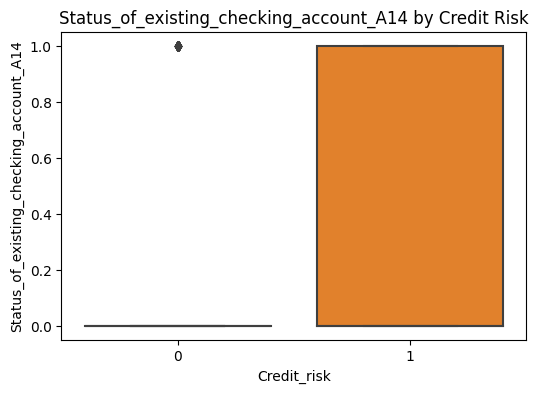

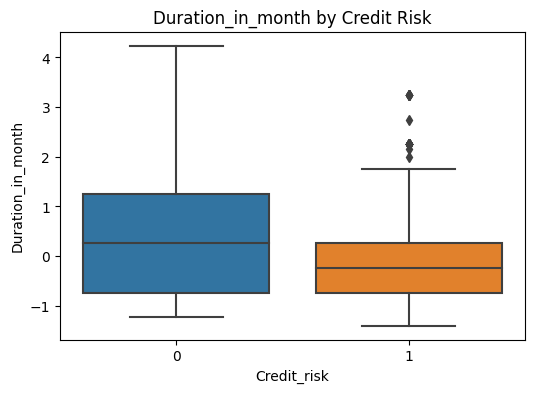

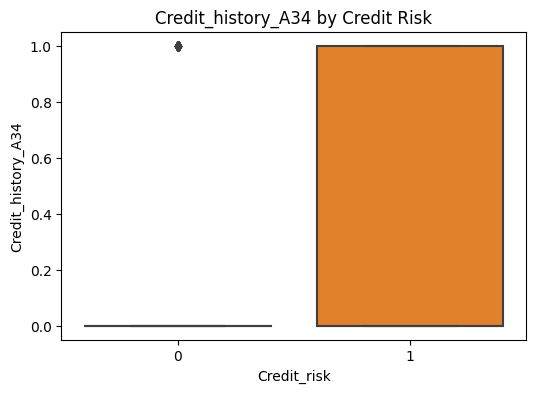

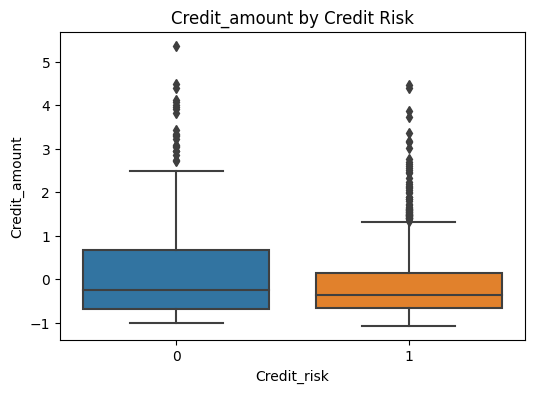

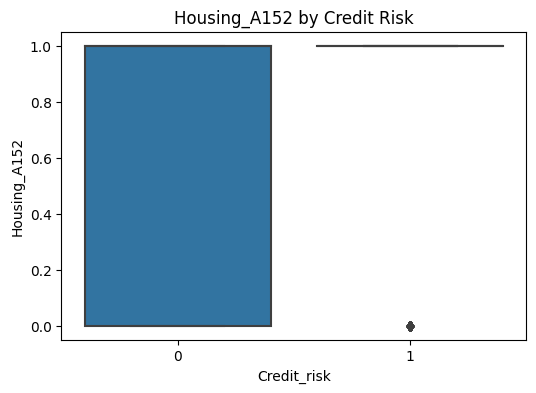

In [30]:
for col in top_corr_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Credit_risk", y=col, data=df_encoded)
    plt.title(f"{col} by Credit Risk")
    plt.show()


In [31]:
# Credit per month (loan burden)
df_encoded["Credit_per_month"] = df_encoded["Credit_amount"] / (df_encoded["Duration_in_month"] + 1)

In [32]:
df_encoded["High_installment_flag"] = (df_encoded["Installment_rate_in_percentage_of_disposable_income"] > 3).astype(int)


In [33]:
df_encoded["Age_Group"] = pd.cut(
    df_encoded["Age_in_years"],
    bins=[0, 25, 40, 100],
    labels=["Young", "Middle", "Senior"]
)

df_encoded = pd.get_dummies(df_encoded, columns=["Age_Group"], drop_first=True)


In [34]:
# Replace old cleaned table
df_encoded.to_sql("cleaned_featured_credit_data", conn, if_exists="replace", index=False)

print("✅ Cleaned + Engineered data saved to 'cleaned_credit_data' table.")
print("Shape:", df_encoded.shape)


✅ Cleaned + Engineered data saved to 'cleaned_credit_data' table.
Shape: (1000, 53)


### Dimentionality and PCA

In [36]:
X = df_encoded.drop(columns=["Credit_risk"])
y = df_encoded["Credit_risk"]

In [37]:
# Run PCA with enough components to explain most variance
pca = PCA(n_components=min(X.shape[0], X.shape[1]))  # full components
X_pca = pca.fit_transform(X)

# Create DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pca_df["Credit_risk"] = y.values


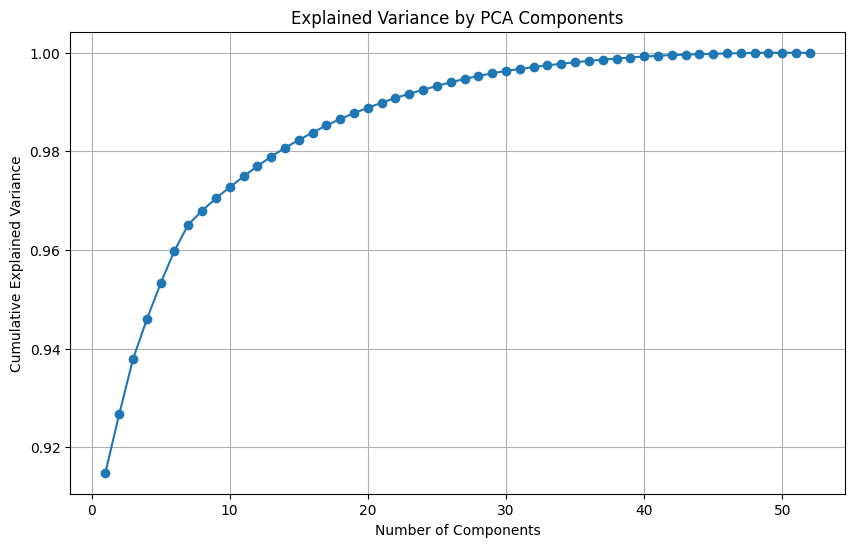

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()


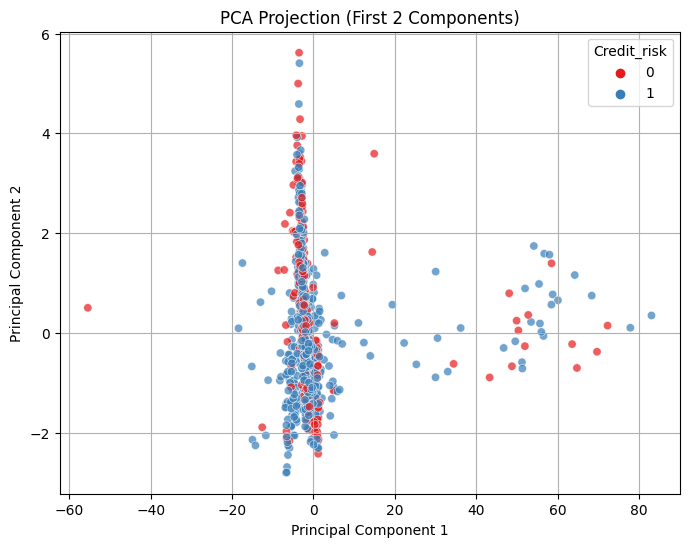

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Credit_risk", palette="Set1", alpha=0.7)
plt.title("PCA Projection (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [40]:
# Save PCA results to DB if needed for later modeling
pca_df.to_sql("pca_credit_data", conn, if_exists="replace", index=False)


1000